In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns

sns.set_context('notebook')
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15,5)
mpl.rcParams['figure.dpi'] = 100

# Homework 4 - Applied Machine learning

## Exercise 1 : Propensity score matching

With this study, we will show that one should take caution when doing using "found" data (doing an observational study). We will show that depending on the time / work spent on the analysis the results can vastly differ and lead to drastically different conclusions.

### Question 1 : A Naive Analysis

First we load the dataset from Robert LaLonde's study ["Evaluating the Econometric Evaluations of Training Programs" (1986)](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)

In [2]:
lalonde_data = pd.read_csv('lalonde.csv')
lalonde_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


We give meaningfull names to the matrix columns, merge the "black" and "hispan" columns into a "ethnicity" columns, which is set to categorical. The treatment column is given the values "treated" and "control" and also set as categorical.

In [3]:
lalonde_data['treat'] = lalonde_data['treat'].map({0: 'treated', 1: 'control'})
lalonde_data['married'] = lalonde_data['married'].map({0: 'No', 1: 'yes'})
lalonde_data['nodegree'] = lalonde_data['nodegree'].map({0: 'No', 1: 'yes'})

lalonde_data['Ethnicity'] = np.where(lalonde_data['black'] == 1, 'Black', '')
lalonde_data.loc[lalonde_data['hispan'] == 1, 'Ethnicity'] = 'Hispanic'
lalonde_data.loc[lalonde_data['Ethnicity'] == '', 'Ethnicity'] = 'White'

lalonde_data = lalonde_data[['id', 'treat', 'age', 'educ', 'Ethnicity', 'married', 'nodegree', 're74', 're75', 're78']]
lalonde_data.columns = ['ID', 'Treatment', 'Age', 'Education', 'Ethnicity', 'Married', 'No School Degree',
                        'Real earnings in 1974', 'Real earnings in 1975', 'Real earnings in 1978']

lalonde_data.set_index('ID',inplace = True)
# Set the categorical data as such
lalonde_data['Treatment'] = lalonde_data['Treatment'].astype('category')
lalonde_data['Ethnicity'] = lalonde_data['Ethnicity'].astype('category')
lalonde_data['Married'] = lalonde_data['Married'].astype('category')
lalonde_data['No School Degree'] = lalonde_data['No School Degree'].astype('category')

lalonde_data.head()

,Treatment,Age,Education,Ethnicity,Married,No School Degree,Real earnings in 1974,Real earnings in 1975,Real earnings in 1978
ID,,,,,,,,,
NSW1,control,37,11,Black,yes,yes,0.0,0.0,9930.0460
NSW2,control,22,9,Hispanic,No,yes,0.0,0.0,3595.8940
NSW3,control,30,12,Black,No,No,0.0,0.0,24909.4500
NSW4,control,27,11,Black,No,yes,0.0,0.0,7506.1460
NSW5,control,33,8,Black,No,yes,0.0,0.0,289.7899


In [4]:
# Extract data of the control groupe and of the treated group in seperate dataframes
control_data = lalonde_data[lalonde_data['Treatment'] == 'control']
treated_data = lalonde_data[lalonde_data['Treatment'] == 'treated']

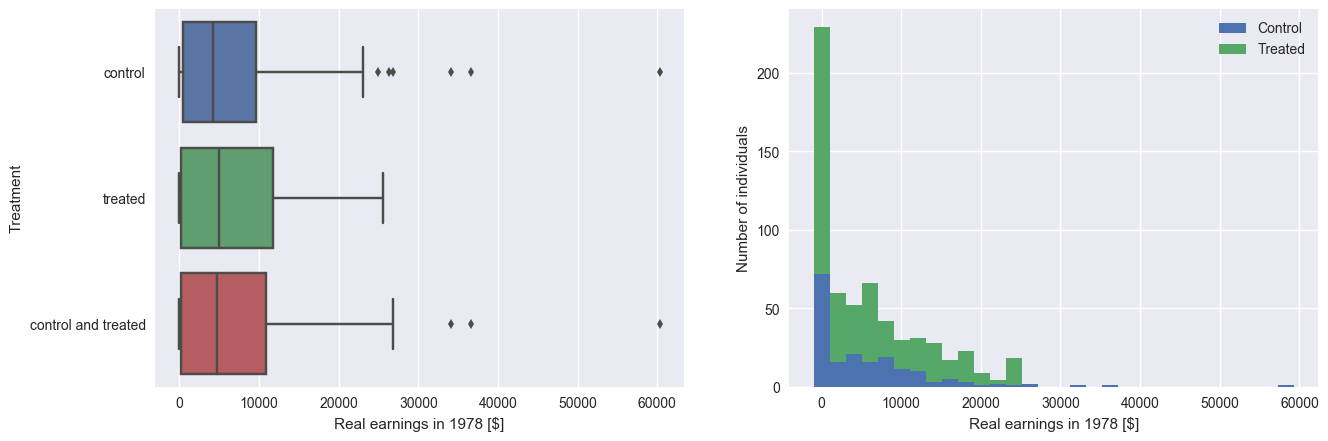

In [5]:
# Create a temporary dataframe storing twice the points, in order to plot them by treatment and together on the same graph
plt_df = lalonde_data.copy()
plt_df['Treatment'] = 'control and treated'
plt_df = pd.concat([control_data, treated_data, plt_df])


fig, (ax1, ax2) = plt.subplots(ncols=2) # sharey=True, figsize=(9, 5)
g = sns.factorplot(x='Real earnings in 1978', y='Treatment',data=plt_df,
                   order = ['control', 'treated','control and treated'], kind='box', ax=ax1)
ax2.hist([control_data['Real earnings in 1978'],treated_data['Real earnings in 1978']],
                     30, stacked=True, align='left', label =['Control', 'Treated'])

ax2.legend()
plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.

ax1.set_xlabel('Real earnings in 1978 [$]')
ax2.set_xlabel('Real earnings in 1978 [$]')
ax2.set_ylabel('Number of individuals')
plt.show()

del plt_df

In [6]:
lalonde_data['Real earnings in 1978'].describe()

count      614.000000
mean      6792.834483
std       7470.730792
min          0.000000
25%        238.283425
50%       4759.018500
75%      10893.592500
max      60307.930000
Name: Real earnings in 1978, dtype: float64

In [7]:
treated_data['Real earnings in 1978'].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: Real earnings in 1978, dtype: float64

In [8]:
control_data['Real earnings in 1978'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: Real earnings in 1978, dtype: float64

The naive analysis would tell us that the individual's real earnings is higher for treated people than for control group. So we should encourage more people to undergo the training and invest more money in the training program. However this analysis is naive, and one should take some time to observe the distribution of features of the two groups (control and treated).

### Question 2 : A closer look at the data

We are not naïve, so we take a closer look at the data, comparing the distributions of the features between control and treated group.

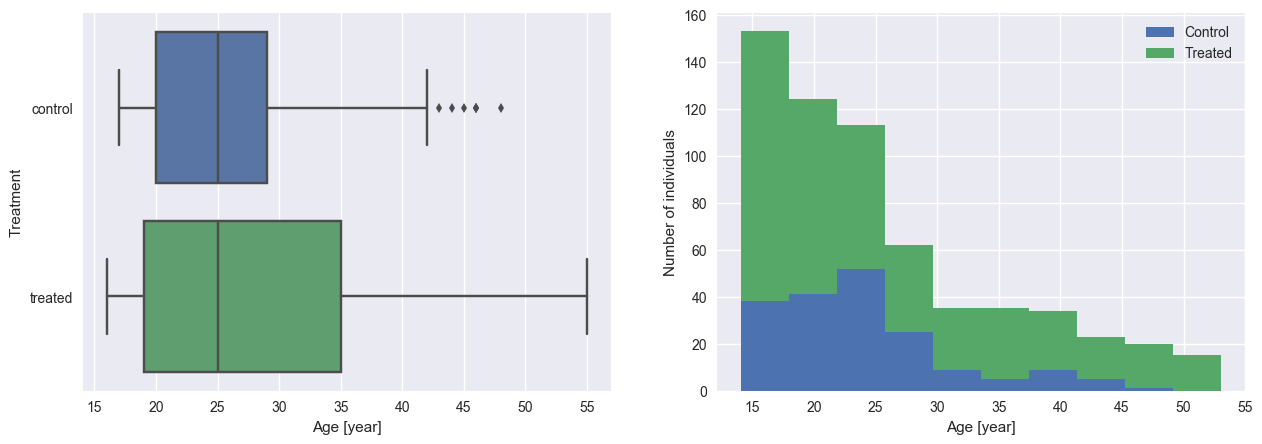

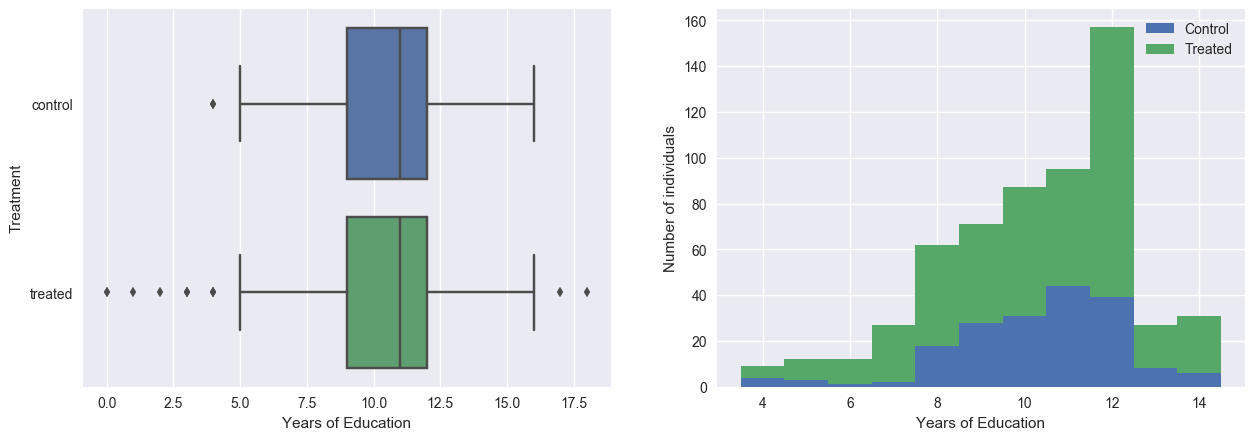

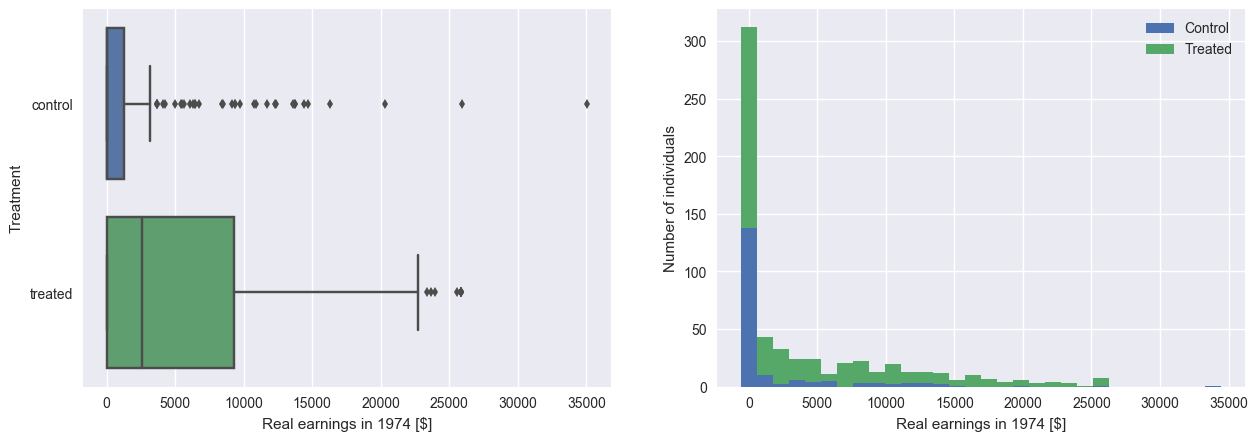

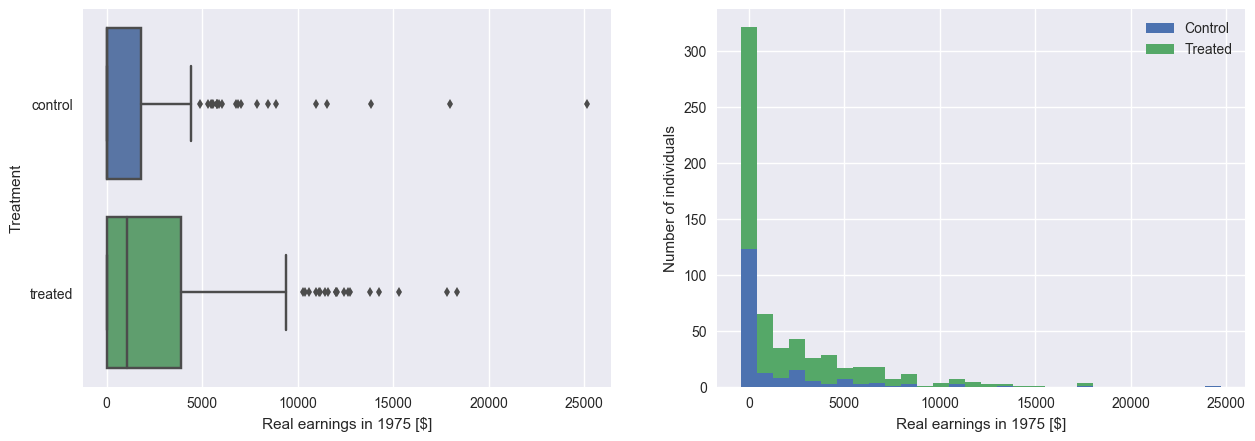

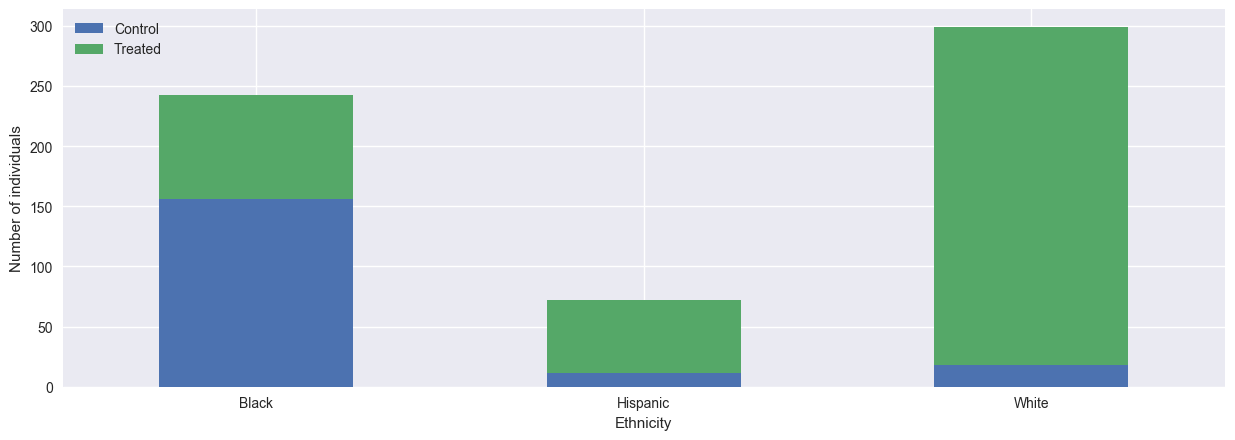

In [9]:
### Box plot and histogram of the Age distribution

fig, (ax1, ax2) = plt.subplots(ncols=2)
g = sns.factorplot(x='Age', y='Treatment',data=lalonde_data, kind='box', ax=ax1)
ax2.hist([control_data['Age'],treated_data['Age']],
         10, stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Age [year]')
ax2.set_xlabel('Age [year]')
ax2.set_ylabel('Number of individuals')
plt.show()



### Box plot and histogram of the number of education years
fig, (ax1, ax2) = plt.subplots(ncols=2)
g = sns.factorplot(x='Education', y='Treatment',data=lalonde_data, kind='box', ax=ax1)
ax2.hist([control_data['Education'],treated_data['Education']],
         np.arange(control_data['Education'].min(), control_data['Education'].max()),
         stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Years of Education')
ax2.set_xlabel('Years of Education')
ax2.set_ylabel('Number of individuals')
plt.show()


### Box plot and histogram of the number of earnings in 1974
fig, (ax1, ax2) = plt.subplots(ncols=2)
g = sns.factorplot(x='Real earnings in 1974', y='Treatment',data=lalonde_data, kind='box', ax=ax1)
ax2.hist([control_data['Real earnings in 1974'],treated_data['Real earnings in 1974']],
         30,stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Real earnings in 1974 [$]')
ax2.set_xlabel('Real earnings in 1974 [$]')
ax2.set_ylabel('Number of individuals')
plt.show()



### Box plot and histogram of the number of earnings in 1975
fig, (ax1, ax2) = plt.subplots(ncols=2)
g = sns.factorplot(x='Real earnings in 1975', y='Treatment',data=lalonde_data, kind='box', ax=ax1)
ax2.hist([control_data['Real earnings in 1975'],treated_data['Real earnings in 1975']],
         30,stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Real earnings in 1975 [$]')
ax2.set_xlabel('Real earnings in 1975 [$]')
ax2.set_ylabel('Number of individuals')
plt.show()




### Histogram of ethnicity
fig, ax1 = plt.subplots(ncols=1)

# We create two temporary dataframes to plot a stack bar plot


tmp_treated = pd.get_dummies(treated_data,columns = ['Ethnicity'])[['Ethnicity_Black','Ethnicity_Hispanic','Ethnicity_White']]
count_ethnicity_treated = pd.Series.to_frame(tmp_treated.sum())
count_ethnicity_treated.columns = ['Treated']

tmp_control = pd.get_dummies(control_data,columns = ['Ethnicity'])[['Ethnicity_Black','Ethnicity_Hispanic','Ethnicity_White']]
count_ethnicity_control = pd.Series.to_frame(tmp_control.sum())
count_ethnicity_control.columns = ['Control']

stacked_plot_df = count_ethnicity_control.copy()
stacked_plot_df['Treated'] = count_ethnicity_treated.Treated

ax1 = stacked_plot_df.plot.bar(stacked=True,ax = ax1);
ax1.set_xticklabels(['Black','Hispanic','White'],rotation = 0)


ax1.set_xlabel('Ethnicity')
ax1.set_ylabel('Number of individuals')
plt.show()

With this vizualisations of the features distributions, we observe multiple things :

- There are more people in the treated group than in the control group.
- The median of the age distribution is the same in the two groups, however the treated group has more people older than the control group which could induce a bias in the salary.
- The distribution of the number of years of education is similar between the two groups, with the exception of a peak around 12.5 years of education which dominate the distribution. This peak could also induce a higher salary in the treated group.
- The distribution of the real earnings in 1974 and 1975 are different between the two category, but there is a lot of 0$ earnings (unemployed).
- Finally, the ethnicity distribution is different between the two groups. The majority of the control group is of "black" ethnicity while the majority of the treated group is of "white" ethnicity. This would also be a cause of higher salary in the treated group due to segregation.

All these differences between features can induce a difference in salary between the two groups, so we must balance the distribution between these groups to be able to conclude on the effectiveness of the training program. For that we will use the propensity score.

### Question 3 : Computing the propensity score

We will compute the propensity score (Probability to be in the treated group) of each individuals by using logistic regression.

In [10]:
from sklearn import linear_model
from sklearn import preprocessing

logistic = linear_model.LogisticRegression()

In [11]:
# First we convert the treatment category to a binary label
le = preprocessing.LabelEncoder()
Y = lalonde_data.Treatment
le.fit(Y)
Y = le.transform(Y)

# Here we print the class to check their order
classes = le.classes_
print('The classes : ')
print(classes)

# We construct the features dataframe by not taking the ID, Label (Treatment) and earnings in 1978
X = lalonde_data[['Age','Education','Ethnicity','Married','No School Degree','Real earnings in 1974',\
                  'Real earnings in 1975']].copy()

# Then we convert the categorical of the features using dummy features
X = pd.get_dummies(X)

# We chose to not normalize the dataset, we tried both and the results were nicer without normalization

The classes : 
['control' 'treated']


In [12]:
# Then we fit our logistic regression model
logistic = logistic.fit(X,Y)

#Obtain the probabilty to be treated
prop_score = logistic.predict_proba(X)
lalonde_data['Propensity Score'] = prop_score[:,1] #Probability to be treated

lalonde_data.head()

,Treatment,Age,Education,Ethnicity,Married,No School Degree,Real earnings in 1974,Real earnings in 1975,Real earnings in 1978,Propensity Score
ID,,,,,,,,,,
NSW1,control,37,11,Black,yes,yes,0.0,0.0,9930.0460,0.539659
NSW2,control,22,9,Hispanic,No,yes,0.0,0.0,3595.8940,0.679562
NSW3,control,30,12,Black,No,No,0.0,0.0,24909.4500,0.362807
NSW4,control,27,11,Black,No,yes,0.0,0.0,7506.1460,0.326654
NSW5,control,33,8,Black,No,yes,0.0,0.0,289.7899,0.320283


We obtain a propensity score for each individuals. It is the probability to belong to the treated group as given by the logistic regression.

### Question 4 : Matching of the individuals

We now create a bipartite graph using the *networkx* library, the left side (0) of the graph is composed of the Control node and the right part the Treated node. The weight of the edges is the absolute difference between the propensity score of each node (let's call it $diff\_abs$). The algorithm that we use to do the matching computes the combination of edges that gives the maximum sum of the weights. As we want to minimize the absolute difference, we replace the weight by $\frac{1}{diff\_abs +1}$ (we add 1 to avoid any division by 0). Now the minimization problem is equivalent to the maximization problem.

In [13]:
import networkx as nx
from networkx.algorithms import bipartite

In [14]:
# Functions which computes the weighted edges between the nodes
def create_edges_vectoralized(df,l,r):
    #Return a list of tuples (u,v,w) where (u,v) is the ID of each node and w the weight

    weights = (np.array(df.loc[l]['Propensity Score'])[:,np.newaxis]\
             - np.array(df.loc[r]['Propensity Score'][np.newaxis, :]))
    weights = (1 / (abs(weights)+1))

    edges = [(l[i], r[j], weights[i,j]) for i in range(len(l)) for j in range(len(r))]
    return edges

In [15]:
def create_bipartite_graph_vectoralized(df):
    # Create the graph
    B = nx.Graph()
    

    l = df[df['Treatment'] == 'control'].index
    r = df[df['Treatment'] == 'treated'].index

    B.add_nodes_from(l, bipartite=0) 
    B.add_nodes_from(r, bipartite=1)
    
    edges = create_edges_vectoralized(df,l,r)
    # Add the edges
    B.add_weighted_edges_from(edges)
    return B


Here we test our function and the matching on a small subset of our dataframe

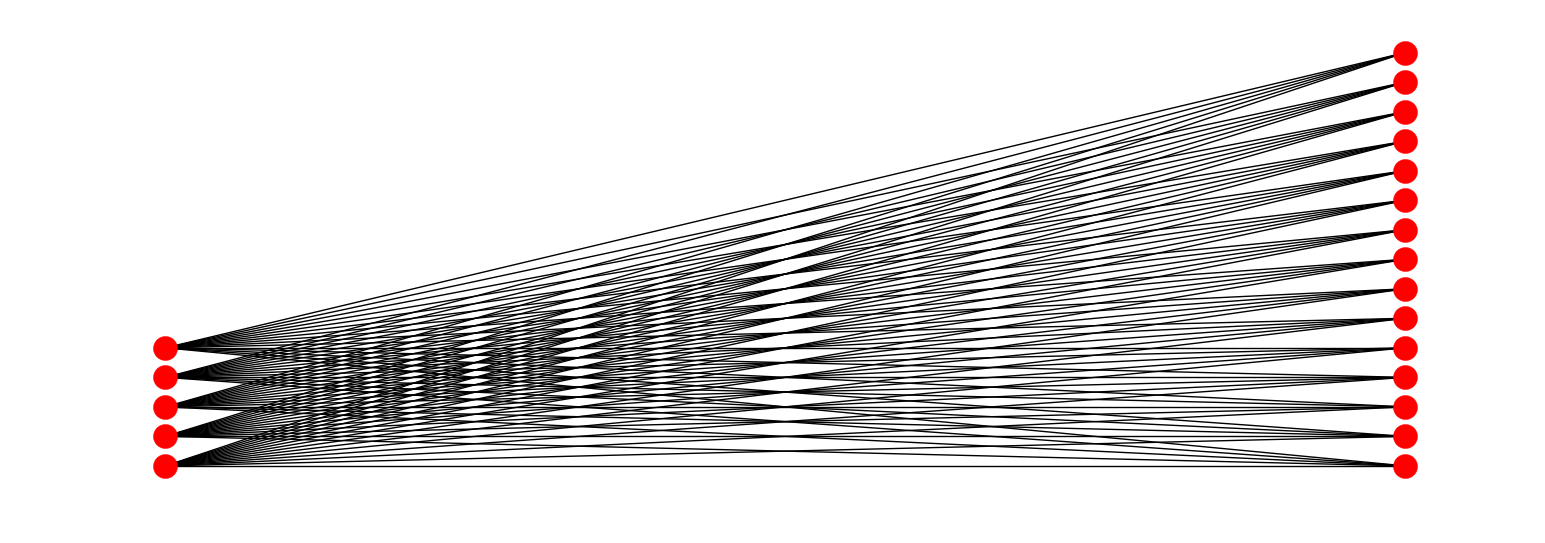

{'NSW15': 'PSID208',
 'NSW157': 'PSID258',
 'NSW58': 'PSID240',
 'NSW66': 'PSID136',
 'NSW74': 'PSID428',
 'PSID136': 'NSW66',
 'PSID208': 'NSW15',
 'PSID240': 'NSW58',
 'PSID258': 'NSW157',
 'PSID428': 'NSW74'}

In [16]:
import warnings

# Take a small random sample
lalonde_df_graph_test = lalonde_data.sample(20)

# Create the bipartite graph
G = create_bipartite_graph_vectoralized(lalonde_df_graph_test)

# Separate by group
left, right = nx.bipartite.sets(G)
pos = {}
# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(left))
pos.update((node, (2, index)) for index, node in enumerate(right))
# Draw test graph


warnings.filterwarnings('ignore')
nx.draw(G, pos=pos)
plt.show()

#Compute the matching
matching = nx.max_weight_matching(G)
matching


Now we use our function on the full dataframe to create the graph and compute the new dataframe with the same number of treated and control individuals. Take caution, the graph creation and matching can take several minutes (particularly the matching is $O(n^3)$).

In [17]:
# Create the full bipartite graph
G = create_bipartite_graph_vectoralized(lalonde_data)

In [18]:
#Compute the full matching
matching = nx.max_weight_matching(G)

In [19]:
new_data = [keys for keys in matching]

lalonde_data_matched = lalonde_data.loc[new_data]
lalonde_data_matched.describe()

,Age,Education,Real earnings in 1974,Real earnings in 1975,Real earnings in 1978,Propensity Score
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,24.713514,10.051351,2136.826762,1601.687322,5955.796948,0.530361
std,8.623663,2.508535,4507.211907,2982.548106,6934.514686,0.224827
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.248418
25%,18.000000,9.000000,0.000000,0.000000,200.231975,0.317739
50%,22.000000,10.000000,0.000000,43.862900,4129.558000,0.475437
75%,27.750000,12.000000,1882.365500,2033.806250,9146.758000,0.773054
max,55.000000,18.000000,35040.070000,25142.240000,60307.930000,0.963815


Now that we have a new dataframe with the same number of individuals in the control and treated group and that they have a similar distribution for their attributes we plot their respective earnings in 1978 (after the treatment)

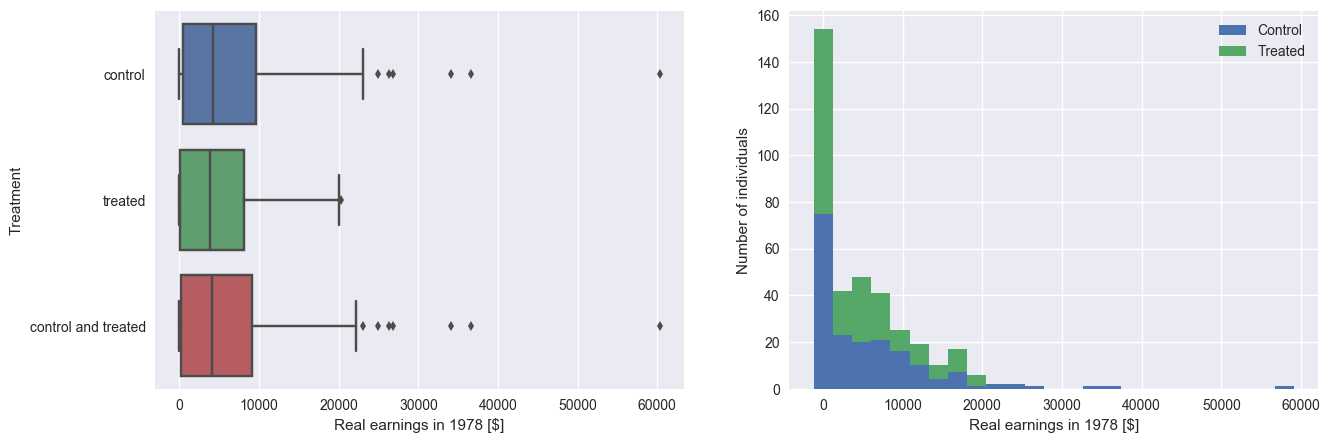

In [20]:
# Create two dataframes that seperate each group
control_data_matched = lalonde_data_matched[lalonde_data_matched['Treatment'] == 'control']
treated_data_matched = lalonde_data_matched[lalonde_data_matched['Treatment'] == 'treated']


# Create a temporary dataframe storing twice the points, in order to plot them by treatment and together on the same graph
plt_df = lalonde_data_matched.copy()
plt_df['Treatment'] = 'control and treated'
plt_df = pd.concat([control_data_matched, treated_data_matched, plt_df])



fig, (ax1, ax2) = plt.subplots(ncols=2) # sharey=True, figsize=(9, 5)
g = sns.factorplot(x='Real earnings in 1978', y='Treatment',data=plt_df,
                   order = ['control', 'treated', 'control and treated'], kind='box', ax=ax1) # hue="kind"

ax2.hist([control_data_matched['Real earnings in 1978'],treated_data_matched['Real earnings in 1978']],
         25, stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Real earnings in 1978 [$]')
ax2.set_xlabel('Real earnings in 1978 [$]')
ax2.set_ylabel('Number of individuals')
plt.show()
del plt_df

Contrary to the naive analysis, we observe that the real earnings in 1978 is higer for the non-treated people than for the treated people. It would mean that the treatment is not efficient.

We also check that the distribution of the individuals attributes is similar. In other word we check that if our matching by propensity score is efficient on this dataset.

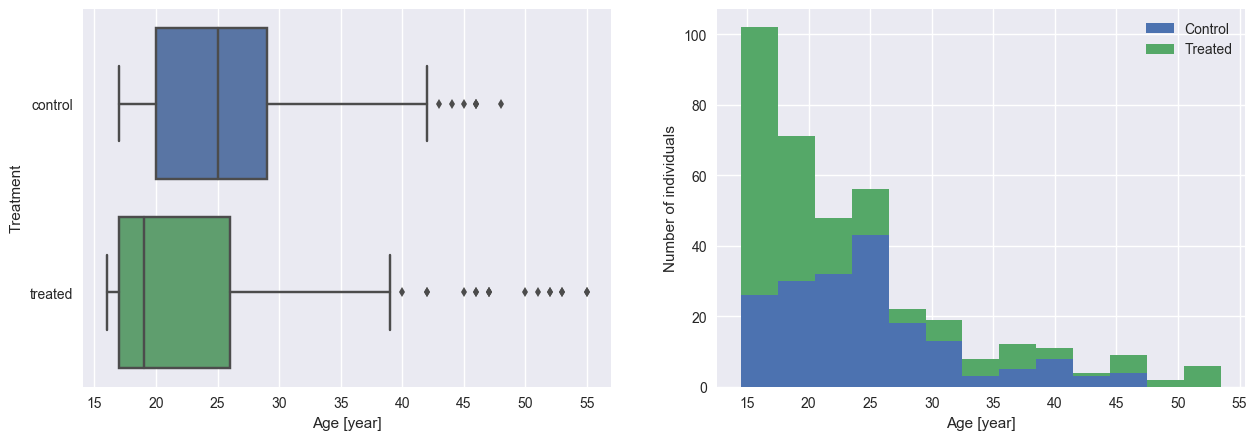

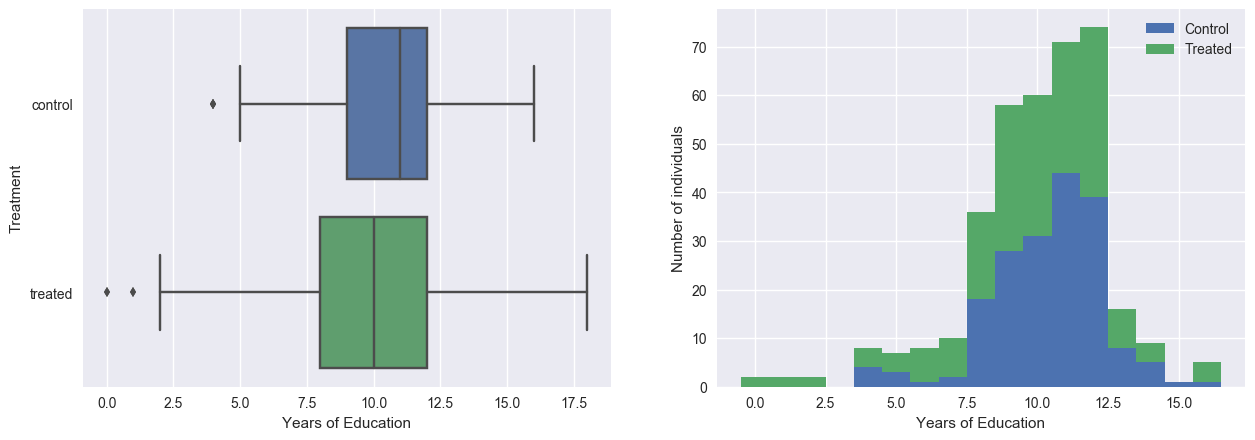

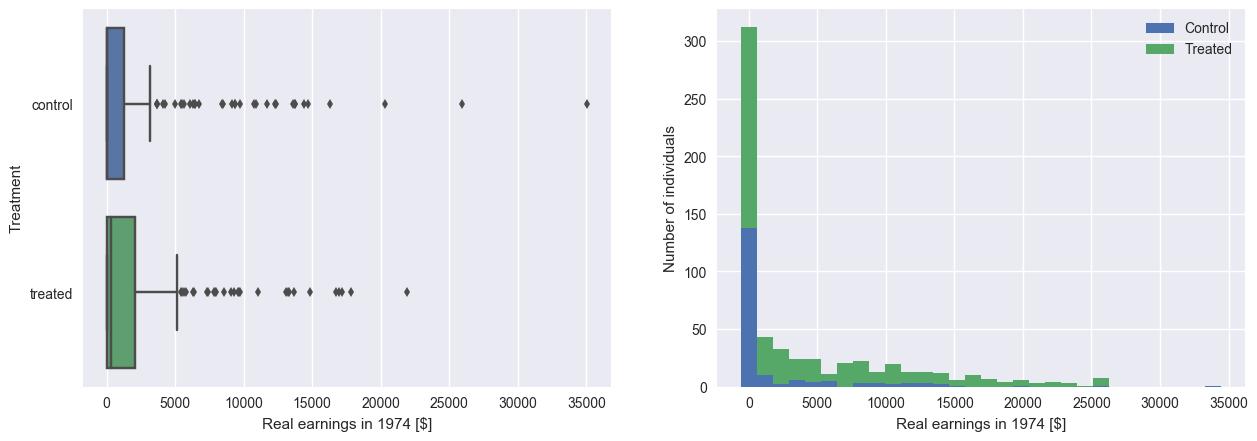

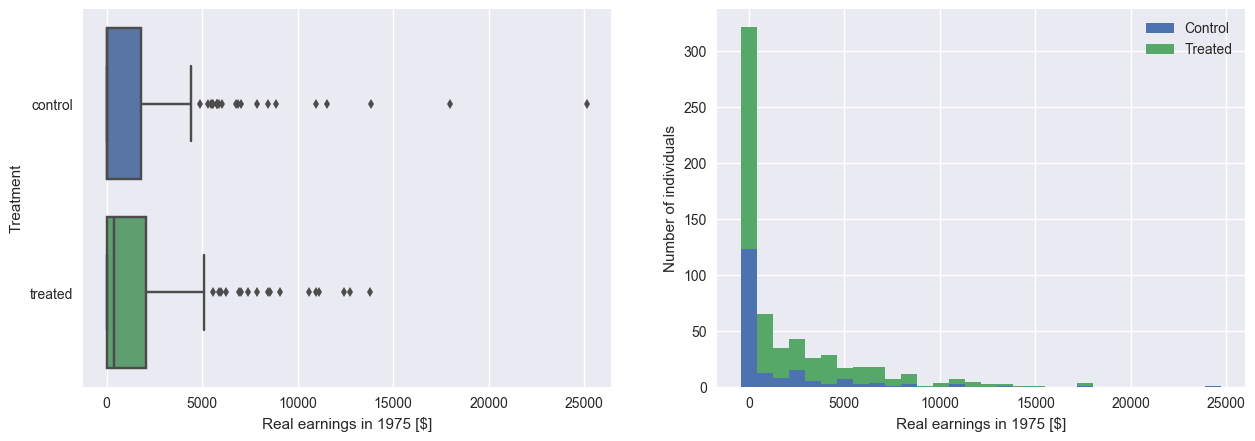

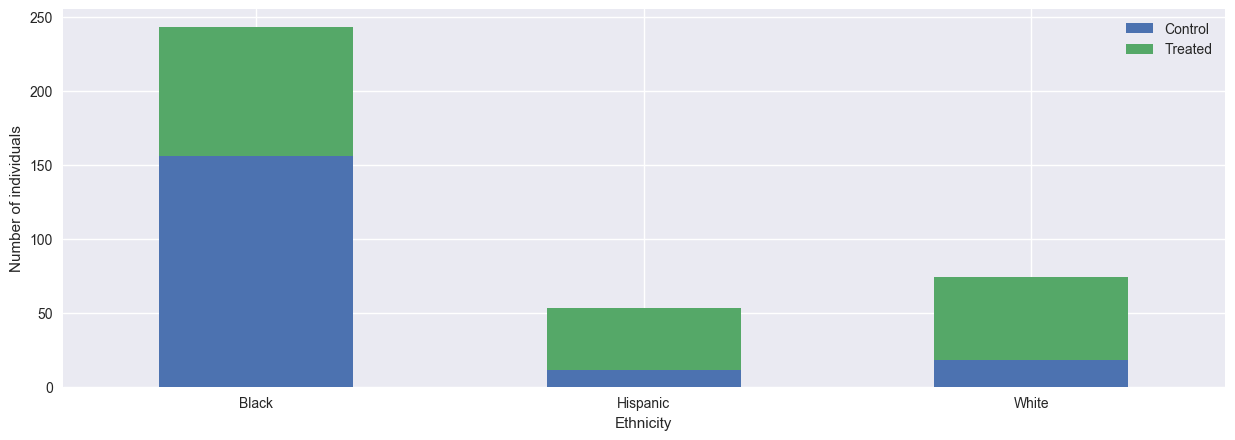

In [21]:

### Box plot and histogram of the Age distribution
fig, (ax1, ax2) = plt.subplots(ncols=2) # sharey=True, figsize=(9, 5)
g = sns.factorplot(x='Age', y='Treatment',data=lalonde_data_matched, kind='box', ax=ax1)
ax2.hist([control_data_matched['Age'],treated_data_matched['Age']],
         13, stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Age [year]')
ax2.set_xlabel('Age [year]')
ax2.set_ylabel('Number of individuals')
plt.show()



### Box plot and histogram of the years of education distribution
fig, (ax1, ax2) = plt.subplots(ncols=2) # sharey=True, figsize=(9, 5)
g = sns.factorplot(x='Education', y='Treatment',data=lalonde_data_matched, kind='box', ax=ax1)
ax2.hist([control_data_matched['Education'],treated_data_matched['Education']],
         np.arange(treated_data_matched['Education'].min(), treated_data_matched['Education'].max()),
         stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Years of Education')
ax2.set_xlabel('Years of Education')
ax2.set_ylabel('Number of individuals')
plt.show()

### Box plot and histogram of the number of earnings in 1974
fig, (ax1, ax2) = plt.subplots(ncols=2)
g = sns.factorplot(x='Real earnings in 1974', y='Treatment',data=lalonde_data_matched, kind='box', ax=ax1)
ax2.hist([control_data['Real earnings in 1974'],treated_data['Real earnings in 1974']],
         30,stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Real earnings in 1974 [$]')
ax2.set_xlabel('Real earnings in 1974 [$]')
ax2.set_ylabel('Number of individuals')
plt.show()



### Box plot and histogram of the number of earnings in 1975
fig, (ax1, ax2) = plt.subplots(ncols=2)
g = sns.factorplot(x='Real earnings in 1975', y='Treatment',data=lalonde_data_matched, kind='box', ax=ax1)
ax2.hist([control_data['Real earnings in 1975'],treated_data['Real earnings in 1975']],
         30,stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Real earnings in 1975 [$]')
ax2.set_xlabel('Real earnings in 1975 [$]')
ax2.set_ylabel('Number of individuals')
plt.show()

### Histogram of the ethnicity distribution
fig, ax1 = plt.subplots(ncols=1)

# We create two temporary dataframes to plot a stack bar plot
tmp_treated = pd.get_dummies(treated_data_matched,columns = ['Ethnicity'])[['Ethnicity_Black','Ethnicity_Hispanic','Ethnicity_White']]
count_ethnicity_treated = pd.Series.to_frame(tmp_treated.sum())
count_ethnicity_treated.columns = ['Treated']

tmp_control = pd.get_dummies(control_data_matched,columns = ['Ethnicity'])[['Ethnicity_Black','Ethnicity_Hispanic','Ethnicity_White']]
count_ethnicity_control = pd.Series.to_frame(tmp_control.sum())
count_ethnicity_control.columns = ['Control']

stacked_plot_df = count_ethnicity_control.copy()
stacked_plot_df['Treated'] = count_ethnicity_treated.Treated

ax1 = stacked_plot_df.plot.bar(stacked=True,ax = ax1);
ax1.set_xticklabels(['Black','Hispanic','White'],rotation = 0)

ax1.set_xlabel('Ethnicity')
ax1.set_ylabel('Number of individuals')

plt.show()

We see that the ethnicity distribution and number of years of education have a more similar distribution than in the first naive analysis. However, the individuals in the control group have a tendency to be older than the one in the treated group. It can lead to salary discrepancy as older people probably earn more money due to the experience acquired in their long carrier. Moreover, the ethnicity are not envely distributed. The earnings are more evenly distributed than before, however we chose to not focus on these two variables because it already depends a lot on the other variable (e.g Age, Years of education, ethnicity ...)

To get rid of this discrepancy, we will try to balance the two groups with more emphasis on the age of individuals.

### Question 5 : Class balancing

We will improve our matched dataset by applying two conditions on it :
- First we only keep the matchs with an absolute difference of propensity score of maximum 0.1
- Then we keep the the matchs with an absolute difference of age of maximum 5 

With these two conditions we will get a smaller dataframe, but with better matching between the two categories.

In [22]:
list_matched = []
# Compute the ID that are true under the above conditions
for keys in matching:
    # Compute the difference of propensity score
    var_prop = abs(lalonde_data.loc[keys]['Propensity Score'] - lalonde_data.loc[matching[keys]]['Propensity Score'])
    # Compute the difference in Age
    var_age = abs(lalonde_data.loc[keys]['Age'] - lalonde_data.loc[matching[keys]]['Age'])
    if (var_prop < 0.1):
        if (var_age <= 5):
            list_matched.append(keys)
# Create new dataframe
lalonde_data_matched = lalonde_data.loc[list_matched]
lalonde_data_matched.describe()
# We keep 116 elements (so 58 treated, 58 control)

,Age,Education,Real earnings in 1974,Real earnings in 1975,Real earnings in 1978,Propensity Score
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,20.706897,10.482759,1718.683862,1373.447413,5492.365293,0.474268
std,4.564546,2.140633,4354.363785,2539.284204,6176.857767,0.239641
min,16.000000,5.000000,0.000000,0.000000,0.000000,0.248418
25%,18.000000,9.000000,0.000000,0.000000,0.000000,0.289797
50%,19.000000,10.000000,0.000000,22.379030,4255.961000,0.337711
75%,23.000000,12.000000,1185.356250,1537.392000,8077.292500,0.675517
max,39.000000,18.000000,35040.070000,13776.530000,36646.950000,0.909918


Let's plot the new distributions :

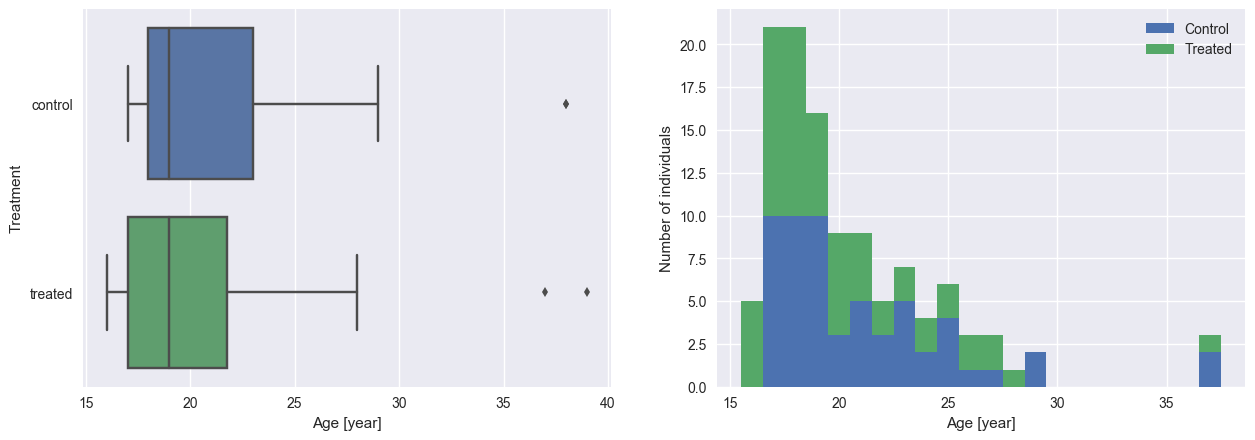

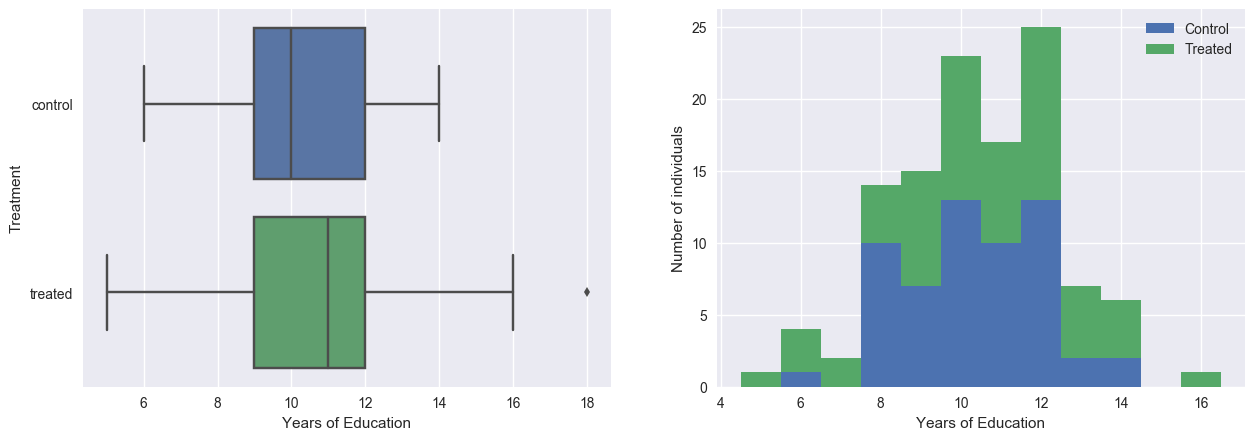

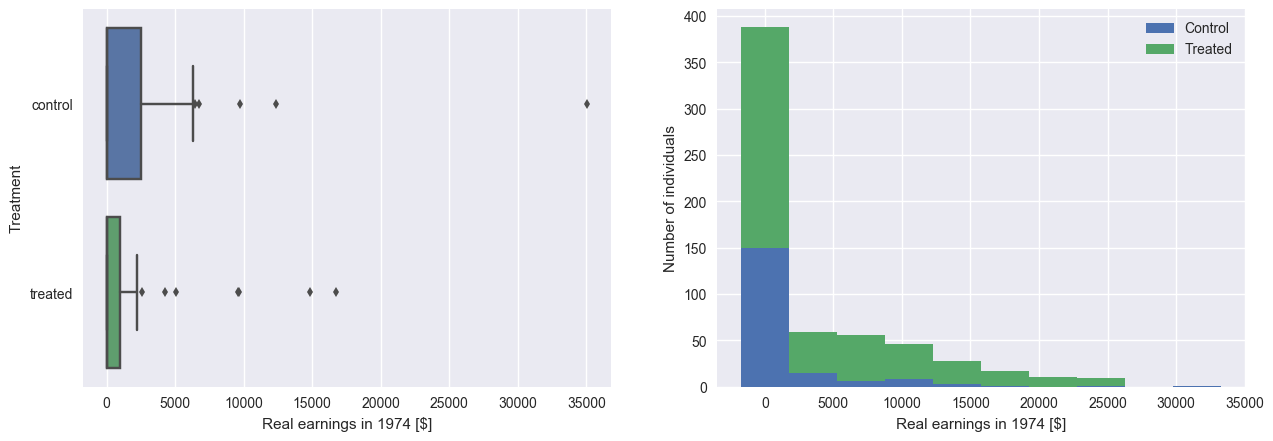

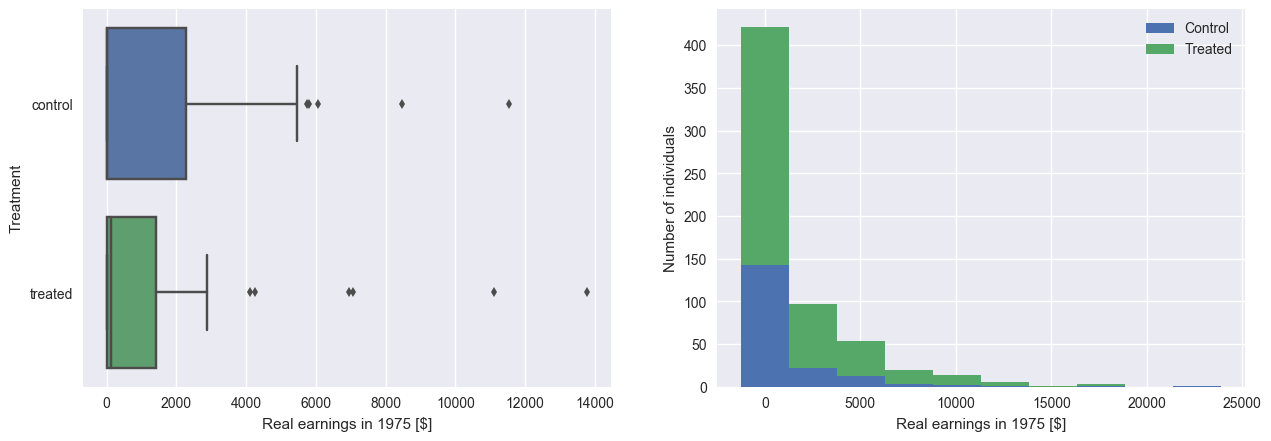

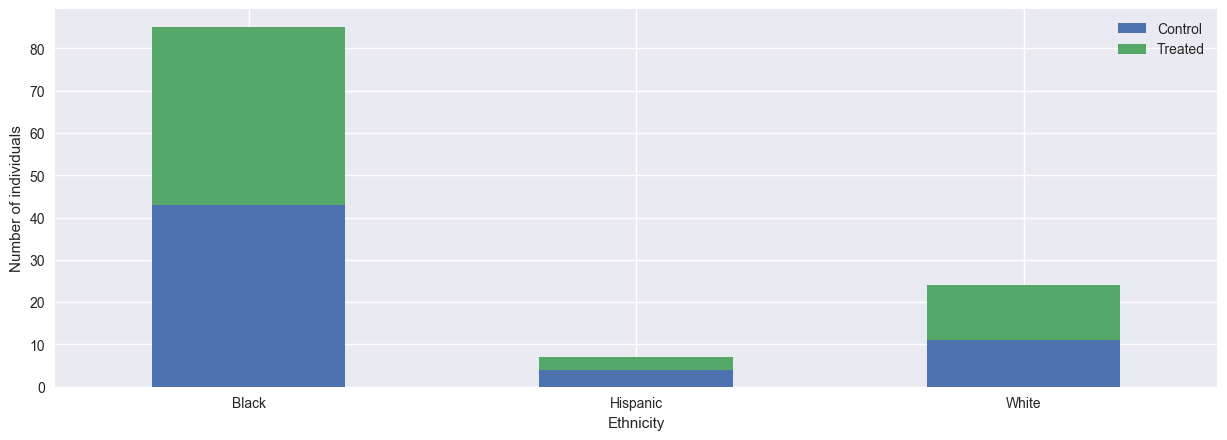

In [23]:
# We create two dataframe for each category
control_data_matched = lalonde_data_matched[lalonde_data_matched['Treatment'] == 'control']
treated_data_matched = lalonde_data_matched[lalonde_data_matched['Treatment'] == 'treated']


### Box plot and histogram of the Age distribution
fig, (ax1, ax2) = plt.subplots(ncols=2)
g = sns.factorplot(x='Age', y='Treatment',data=lalonde_data_matched, kind='box', ax=ax1)
ax2.hist([control_data_matched['Age'],treated_data_matched['Age']],
         np.arange(treated_data_matched['Age'].min(), treated_data_matched['Age'].max()),
         stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Age [year]')
ax2.set_xlabel('Age [year]')
ax2.set_ylabel('Number of individuals')
plt.show()



### Box plot and histogram of the number of years of education
fig, (ax1, ax2) = plt.subplots(ncols=2) # sharey=True, figsize=(9, 5)
g = sns.factorplot(x='Education', y='Treatment',data=lalonde_data_matched, kind='box', ax=ax1)
ax2.hist([control_data_matched['Education'],treated_data_matched['Education']],
         np.arange(treated_data_matched['Education'].min(), treated_data_matched['Education'].max()),
         stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Years of Education')
ax2.set_xlabel('Years of Education')
ax2.set_ylabel('Number of individuals')
plt.show()

### Box plot and histogram of the number of earnings in 1974
fig, (ax1, ax2) = plt.subplots(ncols=2)
g = sns.factorplot(x='Real earnings in 1974', y='Treatment',data=lalonde_data_matched, kind='box', ax=ax1)
ax2.hist([control_data['Real earnings in 1974'],treated_data['Real earnings in 1974']],
         stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Real earnings in 1974 [$]')
ax2.set_xlabel('Real earnings in 1974 [$]')
ax2.set_ylabel('Number of individuals')
plt.show()



### Box plot and histogram of the number of earnings in 1975
fig, (ax1, ax2) = plt.subplots(ncols=2)
g = sns.factorplot(x='Real earnings in 1975', y='Treatment',data=lalonde_data_matched, kind='box', ax=ax1)
ax2.hist([control_data['Real earnings in 1975'],treated_data['Real earnings in 1975']],
         stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()

plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.
ax1.set_xlabel('Real earnings in 1975 [$]')
ax2.set_xlabel('Real earnings in 1975 [$]')
ax2.set_ylabel('Number of individuals')
plt.show()


### Histogram of the ethnicity distribution
fig, ax1 = plt.subplots(ncols=1)

# We create two temporary dataframes to plot a stack bar plot
tmp_treated = pd.get_dummies(treated_data_matched,columns = ['Ethnicity'])[['Ethnicity_Black','Ethnicity_Hispanic','Ethnicity_White']]
count_ethnicity_treated = pd.Series.to_frame(tmp_treated.sum())
count_ethnicity_treated.columns = ['Treated']

tmp_control = pd.get_dummies(control_data_matched,columns = ['Ethnicity'])[['Ethnicity_Black','Ethnicity_Hispanic','Ethnicity_White']]
count_ethnicity_control = pd.Series.to_frame(tmp_control.sum())
count_ethnicity_control.columns = ['Control']

stacked_plot_df = count_ethnicity_control.copy()
stacked_plot_df['Treated'] = count_ethnicity_treated.Treated

ax1 = stacked_plot_df.plot.bar(stacked=True,ax = ax1);
ax1.set_xticklabels(['Black','Hispanic','White'],rotation = 0)

ax1.set_xlabel('Ethnicity')
ax1.set_ylabel('Number of individuals')

plt.show()

We can see that some distributions are clearly similarly distributed between the two groups. Particularly the ethnicity and years of education distributions. The age distributions are also similar but still not equal between the two groups. If we decided to be more restrictive on the age, we would get a too small dataset and our results would not be conclusive. As explained before, we chose not to focus on the earnings in 1974 and 1975.

### Question 6 : A less naive analysis

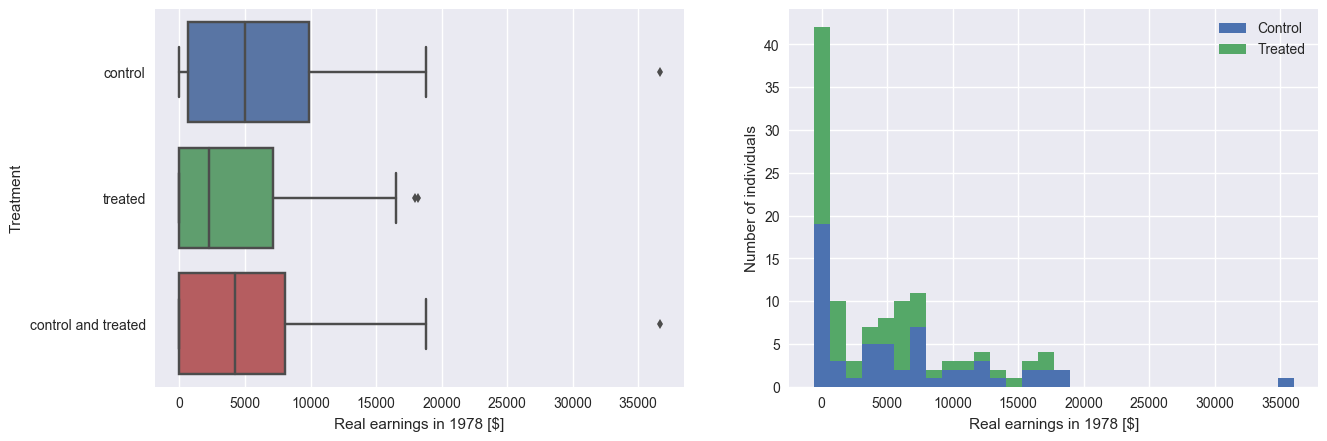

In [24]:
# Create a temporary dataframe storing twice the points, in order to plot them by treatment and together on the same graph
plt_df = lalonde_data_matched.copy()
plt_df['Treatment'] = 'control and treated'
plt_df = pd.concat([control_data_matched, treated_data_matched, plt_df])


fig, (ax1, ax2) = plt.subplots(ncols=2) # sharey=True, figsize=(9, 5)
g = sns.factorplot(x='Real earnings in 1978', y='Treatment',data=plt_df,
                   order = ['control', 'treated','control and treated'], kind='box', ax=ax1)
ax2.hist([control_data_matched['Real earnings in 1978'],treated_data_matched['Real earnings in 1978']],
         30, stacked=True, align='left', label =['Control', 'Treated'])
ax2.legend()
plt.close(g.fig) # factorplot creates its own figure, so it produces an empty one here. We therefore close it.

ax1.set_xlabel('Real earnings in 1978 [$]')
ax2.set_xlabel('Real earnings in 1978 [$]')
ax2.set_ylabel('Number of individuals')
plt.show()
del plt_df

Contrary to the naive analysis, we see that the real earnings in 1978 is higher for the control group than for the group that underwent training. We can conclude that the training program was not helpful in increasing the income of the treated individuals.
On the methodology, we can conclude that it's important to be careful when studying "found" data as we've seen drastically different results between a naive and more thorough analysis.

## Exercise 2 : Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import multiprocessing

>Note: in order to compute faster we will parallelize the grid search and for that we need to know how many cores are available to feed them with work.

In [2]:
#Check how many cores are available for work.
nb_cores = multiprocessing.cpu_count()

We first load the 20newsgroup dataset.

In [3]:
#load the 20newsgroup dataset.
newsgroups = fetch_20newsgroups(subset='all')
#X represents the features
X = newsgroups.data
#y represents the targets
y = newsgroups.target
#names represents the target names
names = newsgroups.target_names

Let's have a look at what a message looks like:

In [4]:
print(newsgroups.data[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




Now, we first split our dataset into a training and testing set (10% for testing). We will use 10-fold cross-validation to tune the parameters of the model (Random forest tree). We fit TF-IDF vectorizer on the training set only and then vectorize the testing and the training set using the results of the training. We don't want to put some information from the testing set into the training set, that's why we decided to not fit the vectorizer on the whole dataset. We decided to make it like that in order to be more consistent and have better results compared to starting with the computation of the TF-IDF features for every article. Note that we use the stratify argument in 'train_test_split' function in order to keep the proportions of the categories in the training and testing sets equal to the proportion in the whole set.

In [5]:
#Creation of a training and testing set with defined parameters.
#percentage for the testing set.
p_test = 0.1
#we set the seed at 1.
seed=1

#creation of the 4 sets.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = p_test, random_state=seed, stratify = y)

#We create the vectorizer in order to compute the TF_IDF using only training set.
vectorizer = TfidfVectorizer().fit(X_train)
#compute the TF_IDF of training set
X_train = vectorizer.transform(X_train)
#compute the TF_IDF of the testing set
X_test = vectorizer.transform(X_test)

Let's train a Random Forest on our training set.

In [6]:
#The model is the randomforest.
model = RandomForestClassifier()
#we train the model on our training set.
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [7]:
#we got the prediction of this model with the testing set.
prediction = model.predict(X_test)
#finally we obtain an accuracy score.
accuracy = accuracy_score(prediction,y_test)

In [8]:
print('With the default parameter on a random forest model we obtain an accuracy of:',accuracy)

With the default parameter on a random forest model we obtain an accuracy of: 0.659416445623


Now we try to improve our accuracy by fine-tuning the parameters of our predictor on our validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". We will use a stratified 10-fold cross-validation.

>#### Be careful: the following cell takes very long time to run. (125 min on our computer (4 cores).)

In [119]:
#Again, the model is the randomforest.
model = RandomForestClassifier()
#we define k for the k-fold cross-validation.
k=10
#We set the range of the parameters we want to fine tune.
n_estimators = 120
max_depth = 50
n_estimators = range(1,n_estimators,10)
max_depth = range(1,max_depth,5)
#defining the tuned parameters
tuned_parameters = {
    'n_estimators':n_estimators,
    'max_depth':max_depth
}

#create the stratified k-fold for the cross validation.
k_fold_strat = StratifiedKFold(10,random_state=seed,shuffle=True)

#we create the grid that use grid search to fine tune the parameters: we use the random forest model with the defined tune
#parameters and the stratified k fold, note that we use n_jobes to set parallelize the task splitted in how many cores
#we have available and we refit our model at the end (verbose is just for helping to visualize where we are.)
grid = GridSearchCV(model,tuned_parameters,cv=k_fold_strat,scoring='accuracy',n_jobs=nb_cores, refit=True,verbose=1)

#we fit the grid with our training set
grid.fit(X_train,y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 11.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 43.8min
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed: 125.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': range(1, 120, 10), 'max_depth': range(1, 50, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [120]:
#Now that the grid search do it's job, we take the best estimator between all the tested ones in order to compute the accuracy
#with the testing sets.
best_estimator = grid.best_estimator_
#we make prediction with the testing sets
prediction = best_estimator.predict(X_test)
#we finally compute the accuracy.
accuracy = accuracy_score(prediction,y_test)

In [121]:
print('With good parameters on a random forest model we obtain an accuracy of:',accuracy)

With good parameters on a random forest model we obtain an accuracy of: 0.830769230769


With the parameter fine-tuning we improved our accuracy by 27% !

In [130]:
#We create a dataframe with all the results of our process.
df_grid = pd.DataFrame(grid.cv_results_)
#let's have a look at the head.
df_grid.tail()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
115,70.899185,0.313735,0.806320,0.978316,46,71,"{'max_depth': 46, 'n_estimators': 71}",10,0.803991,0.976339,...,0.800592,0.975640,0.827607,0.981012,0.800475,0.978988,1.372057,0.008498,0.010600,0.002104
116,79.214353,0.371439,0.810094,0.978283,46,81,"{'max_depth': 46, 'n_estimators': 81}",7,0.802230,0.977453,...,0.814793,0.978849,0.824645,0.980161,0.805819,0.979184,1.106976,0.017245,0.007043,0.001794
117,89.659582,0.416112,0.813926,0.980596,46,91,"{'max_depth': 46, 'n_estimators': 91}",4,0.809272,0.983024,...,0.815385,0.979242,0.825829,0.983304,0.818290,0.980886,1.479373,0.026843,0.008485,0.001827
118,104.630193,0.488950,0.820765,0.981874,46,101,"{'max_depth': 46, 'n_estimators': 101}",2,0.816315,0.981386,...,0.827219,0.983433,0.840047,0.980947,0.809976,0.980690,4.181525,0.042770,0.009070,0.000885
119,113.094302,0.490555,0.824067,0.982044,46,111,"{'max_depth': 46, 'n_estimators': 111}",1,0.815728,0.978108,...,0.818935,0.981927,0.837678,0.982715,0.822447,0.983374,8.797940,0.128561,0.007523,0.001743


In [139]:
#we extract the best rank test score
best_grid = df_grid[df_grid['rank_test_score']==1]
best_grid

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
119,113.094302,0.490555,0.824067,0.982044,46,111,"{'max_depth': 46, 'n_estimators': 111}",1,0.815728,0.978108,...,0.818935,0.981927,0.837678,0.982715,0.822447,0.983374,8.79794,0.128561,0.007523,0.001743


In [144]:
max_depth = list(best_grid['param_max_depth'])[0]
n_estimator = list(best_grid['param_n_estimators'])[0]
print('The best parameters are : ', max_depth , '(max depth) and', n_estimator, '(n_estimator).')

The best parameters are :  46 (max depth) and 111 (n_estimator).


>We see that the best parameters are for the last ones on the dataframe, so we can infer that the optimal parameters are even bigger. However, we did not consider bigger parameters due to the high computation time. We already have a quite good accuracy and the trade-off computation-time/accuracy is not worth.

Here, we display a confusion matrix to get some insight about our results.

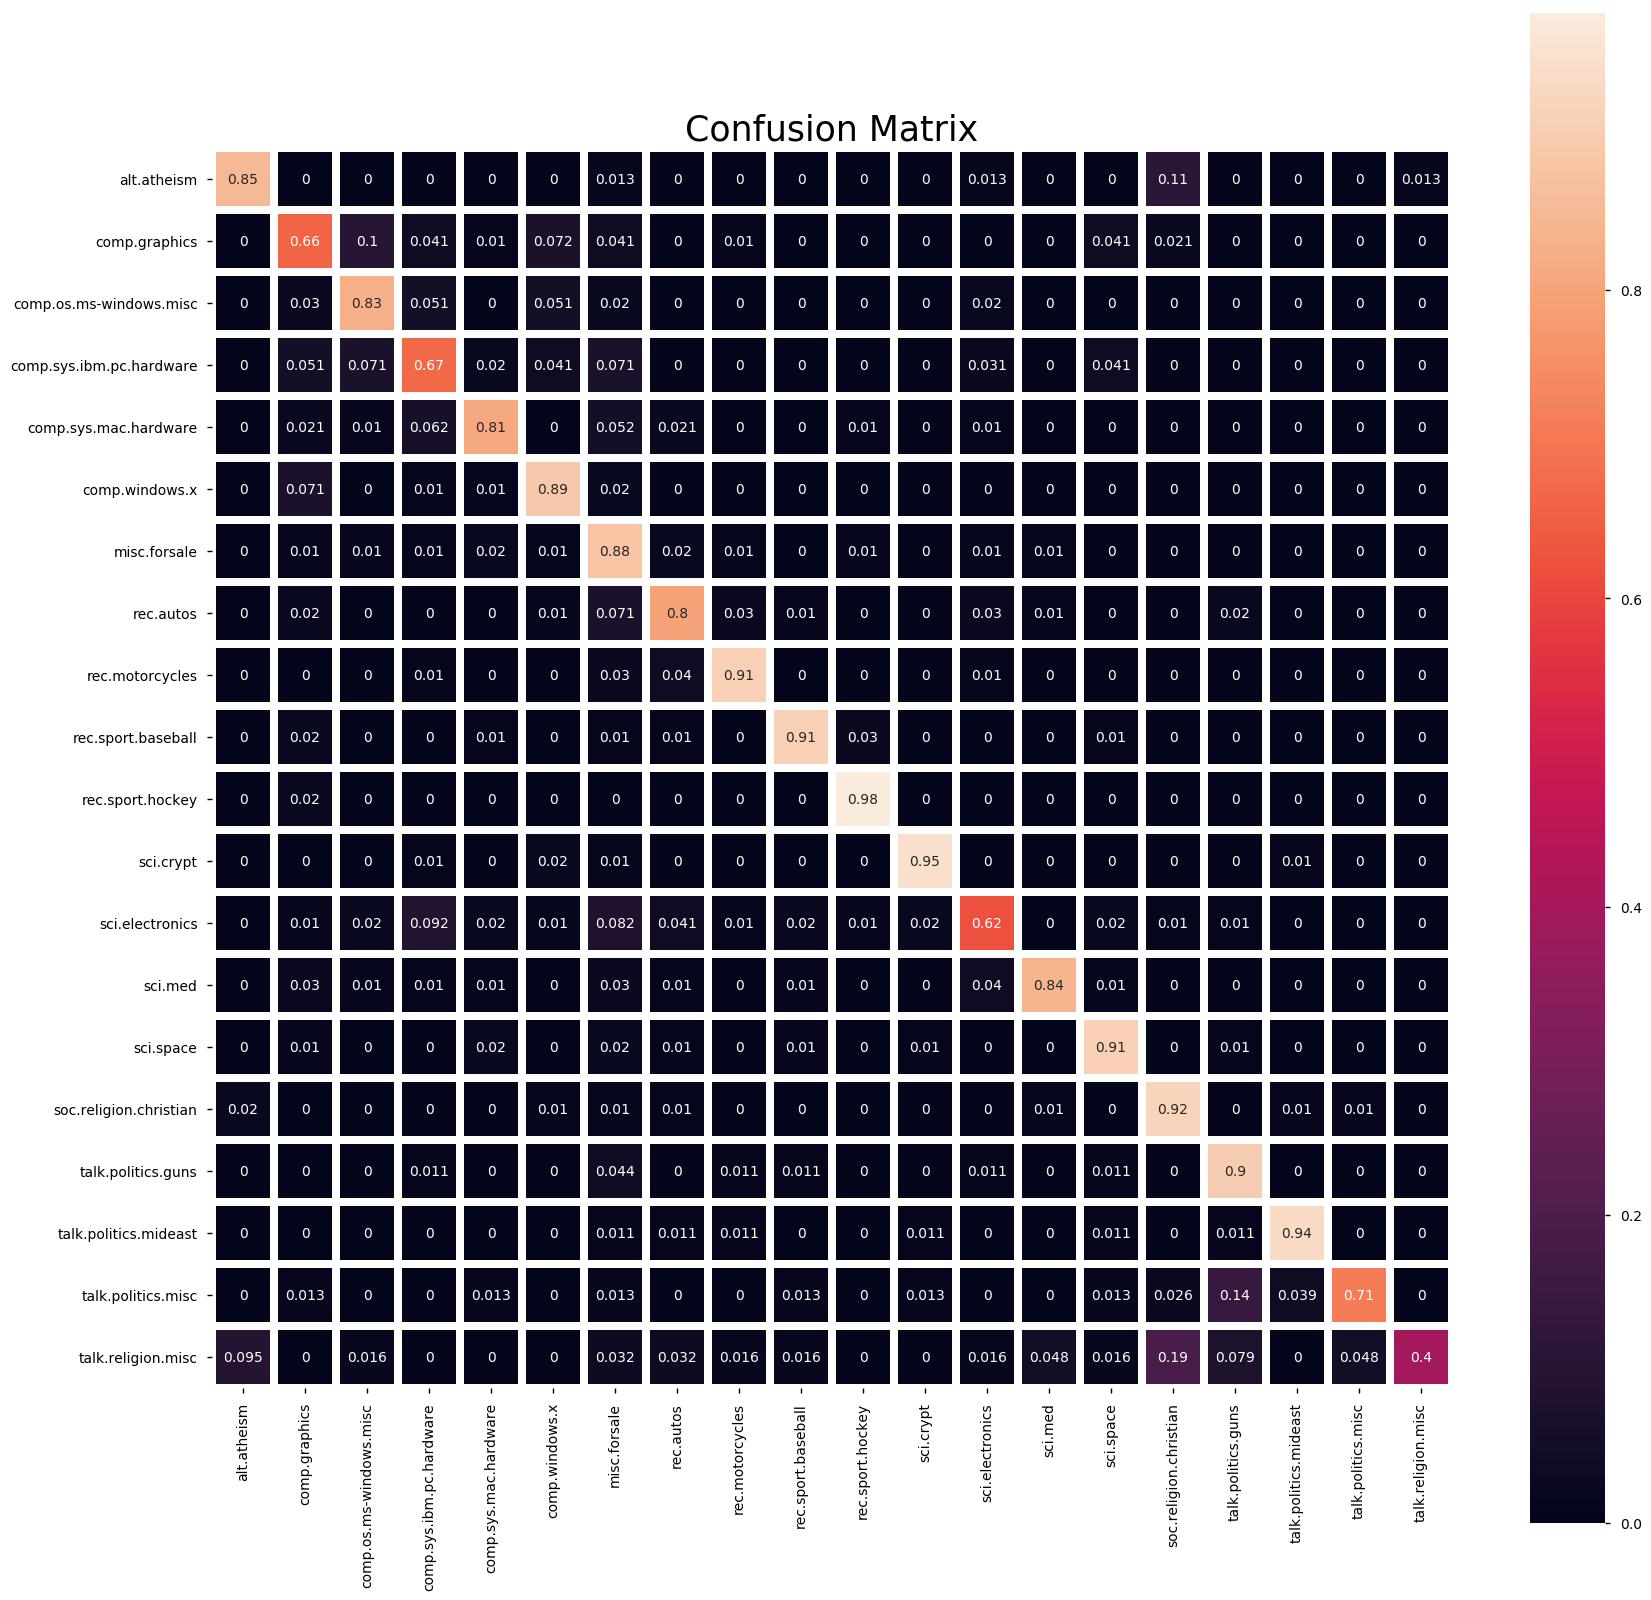

In [93]:
confusion_mat = confusion_matrix(y_test,prediction)
confusion_mat = pd.DataFrame(confusion_mat, index = names, columns = names)
confusion_mat = confusion_mat.div(confusion_mat.sum(axis=1),axis=0)
plt.figure(figsize=(20,20))
sns.heatmap(confusion_mat, square=True, linecolor='w',linewidths=5,annot=True)
plt.title('Confusion Matrix',fontsize=25)
plt.show()

>*Some comments*:  
We directly see that globaly there is only few mistakes. The lowest value in the diagonal are: 
- talk.religion.misc with only 40% of accuracy. However, it seems to be really hard to distinguish the cases where the subject is 'talk.religion.misc' or 'soc.religion.christian': even for us, humans, this could be an hard task !
- sci.electronics with only 62% of accuracy. However, again this seems already a good accuracy because there is some electronics in almost all the sections: 'comp.sys.imb.pc_hardware', 'comp.sys.mac.hardware' or 'misc.forsale' for example.

>The most common mistakes in our classification is for the 'talk.religion.misk' and 'soc.religion.christian' that we already discussed above and for 'talk.politics.misc' and 'talk.politics.guns' where this is again hard to separate the two cases.


We will now analyze the feature importance of our model to get a better understanding of the classification.

In [42]:
#we take the feature_importances of our model.
feature_importance = model.feature_importances_
#let's have a look.
feature_importance

array([ 0.00031942,  0.00030582,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [43]:
#we can now sort the features by the importances we add with the numpy method np.argsort which will return
#a sorted list with conservation of the index and we take in the reversed sens in order to have the most important
#feature corresponding to the first position in the list
importance = np.argsort(feature_importance)[::-1]
#let's have a look.
importance

array([ 51455,  42505, 130227, ..., 101761, 101763,  81127], dtype=int64)

In [44]:
#we take the 20 most important features.
most_important_feature = importance[:20]
#we create this dictionnary in order to return us the features in function of the index we passed.
index_to_words = {v: k for k,v in vectorizer.vocabulary_.items()}
#for every index in most_important_feature we look at its corresponding word.
best_feature = [index_to_words[word] for word in most_important_feature]
#we print this words.
print(best_feature)

['clipper', 'bike', 'sale', 'car', 'windows', 'space', 'dod', 'encryption', 'cars', 'hockey', 'baseball', 'god', 'game', 'israel', 'team', 'athos', 'nhl', 'rutgers', 'the', 'offer']


>The most important features we obtained with our model are almost every time words with strong correlation with certain categories. For example the words hockey, baseball or windows are correlated with sports, sports, technologies. This can help us to easily identify the subject of the text. Surprisingly we can see that the word 'the' is present and this is a bit confusing since it doesn't give meaningful information on the subject.